# FashionMNIST

![gif](assets/embedding.gif)


You should solve the FashionMNIST problems and be able to recognize clothes thanks to AI.

	If necessary you can un-comment the next line and run it to install this notebook depedencies

In [12]:
# !pip install torch torchvision numpy matplotlib

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
# Transform each image into tensor
transform = transforms.Compose([transforms.ToTensor()])

# Set the training loader
train_data = datasets.FashionMNIST('../data', train=True, download=True, transform=transform)
# Set the testing loader
test_data = datasets.FashionMNIST('../data', train=False, download=True, transform=transform)

0.1%

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


100.6%


3.3%

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%
119.3%

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



# The dataset

 - `train_data` is only for training your model.
 - `test_data`  is only for testing your model.

## Shape

```python
train_data = [
	[image], [label] # 1st example
	[image], [label] # 2nd example
	[image], [label] # 3rd example
	[image], [label] # 4th example
	... # 4th example
]
```

There's 60 000 examples in the train set, and 10 000 in the test set

### Image

An image is 28*28 in black & white 

You can access the first image this way:

```python
image_0 = data[0][0]
```

### Label

A label is an integer between 0 and 9 (included) 

You can access the first label this way:

```python
label_0 = data[0][1]
```

Here is the detail of each label

| Label | Description |
|:-|:-:|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |



In [ ]:
print("Train len : " + str(len(test_data)))
print("Test len : " + str(len(train_data)))

Train len : 10000
Test len : 60000


In [ ]:
print("Image Size: " + str(train_data[0][0].shape))

Image Size: torch.Size([1, 28, 28])


In [ ]:
label_dic = {
	0: "T-shirt/top",
	1: "Trouser",
	2: "Pullover ",
	3: "Dress ",
	4: "Coat ",
	5: "Sandal ",
	6: "Shirt ",
	7: "Sneaker ",
	8: "Bag ",
	9: "Ankle boot"
}

def plot_one_example(example):
	plt.imshow(example[0].view(28, 28), cmap="gray")
	plt.title("Label class {}: {}".format(example[1], label_dic[example[1]]))
	plt.show()

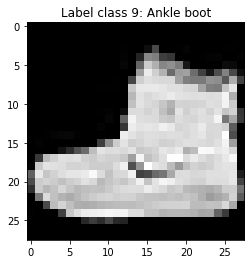

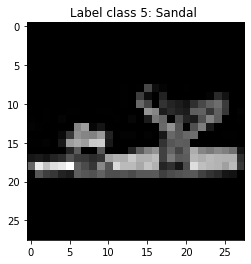

In [ ]:
plot_one_example(train_data[0])
plot_one_example(train_data[-1])

Time to train a model to predict the label of an image !

# 🚀 Good Luck 

Use cuda if available to improve performances

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Hyperparameters
We define the following hyperparameters for training:
1. Number of Epochs - the number times to iterate over the dataset
2. Batch Size - the number of data samples propagated through the network before the parameters are updated
3. Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [6]:
epochs=15
batch_size=64
learning_rate = 1e-3

## Dataloaders
Dataloaders are very usefull to iterate over the data set in batches

In [7]:
# Dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Functions

In [8]:
def print_random_pred(test_dataloader, model, rows=3, cols=8):
    """
    Function print_random_pred prints a grid of @rows x @cols @model predictions on the test dataset.
    """
    dataiter = iter(test_dataloader)
    images, labels = dataiter.next()

    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

    for i in range(rows):
        images, labels = dataiter.next()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for j in range(cols):
            idx = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * cols + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(images[idx].view(28, 28), cmap="gray")
            ax.set_title("pred: {}\ntrue: {}".format(label_dic[int(predicted[idx].numpy())], label_dic[int(labels[idx].numpy())]))

    plt.show()

In [ ]:
def print_acc_by_class(test_dataloader, model, label_dic=label_dic):
    """
    Prints accuracy of @model prediction on the test set by class 
    """
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in label_dic.values()}
    total_pred = {classname: 0 for classname in label_dic.values()}

    # again no gradients needed
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label_dic[int(label.numpy())]] += 1
                total_pred[label_dic[int(label.numpy())]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class {classname:12s} is {accuracy:.1f}%')

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Train @model
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    train_acc = correct / size
    
    return train_loss, train_acc

In [ ]:
def test_loop(dataloader, model, loss_fn):
    """
    Test @model
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc = correct / size
    
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, test_acc

In [ ]:
def train_test_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        
        loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(loss)
        train_acc.append(acc)
        
        print()
        
        loss, acc = test_loop(test_dataloader, model, loss_fn)
        test_loss.append(loss)
        test_acc.append(acc)
    
    print("Training complete!")
    
    plt.plot(train_loss, '-', label="Training")
    plt.plot(test_loss, '-', label="Validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Training and validation loss")
    plt.show()
    
    plt.plot(train_acc, '-', label="Training")
    plt.plot(test_acc, '-', label="Validation")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Training and validation accuracy")
    plt.show()

## Model Selection

Neural networks learn by modeling the human learning process: they take in data, look for patterns, and assimilate those patterns to create logical rules for processing data or for identifying things. Thus they are widely used in computer vision problems.

In the following sections we will use various neural networks models and architecture to classify our data and compare their performance.

The existing litterature suggests to use Convolutionnal Neural Networks for image classification, as said Athanasios Voulodimos, Nikolaos Doulamis, Anastasios Doulamis and Eftychios Protopapadakis in [Deep Learning for Computer Vision: A Brief Review](https://www.hindawi.com/journals/cin/2018/7068349/).

Yet our first model will be a basic neural network with linear layers, it will give us a comparison base to rely on to mesure the performance of CNNs on our dataset.

For comparison purposes all our models will use the same loss function and optimizer :
- Loss function: When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value. Common loss functions include Mean Square Error for regression tasks, and Negative Log Likelihood for classification. We will use Cross Entropy Loss (``nn.CrossEntropyLoss``) which combines Log Softmax and Negative Log Likelihood.
- Optimization: optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed. In this example we use Stochastic Gradient Descent (SGD optimizer). There are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

Other ressources:
- [The Essential Guide to Neural Network Architectures](https://www.v7labs.com/blog/neural-network-architectures-guide)
- [A survey of image classification methods and techniques for improving classification performance](https://www.tandfonline.com/doi/full/10.1080/01431160600746456)


### 1. Basic NN
Let's start with a very simple neural network with 3 linear layers.
This model is described in [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

How it works :
1. ``torch.flatten`` : convert each 28x28 image into a one dimension tensor of 784 pixel values.
2. ``nn.Linear`` : The linear layer is a module that applies a linear transformation on the input using its stored weights and biases.
3. ``F.relu`` : Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena.
4. ``nn.Softmax``: The last linear layer of the neural network returns logits (raw values in $[-inf, +inf]$) which are passed to the ``nn.Softmax`` module. The logits are scaled to values $[0, 1]$ representing the model’s predicted probabilities for each class. ``dim`` parameter indicates the dimension along which the values must sum to 1.

![architecture](assets/basic_nn.png)

In [ ]:
# Model
class BasicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.softmax(x)

In [ ]:
model = BasicNN().to(device)
print(model)

BasicNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Epoch 1
-------------------------------
loss: 2.303107  [    0/60000]
loss: 2.302474  [ 6400/60000]
loss: 2.302178  [12800/60000]
loss: 2.302035  [19200/60000]
loss: 2.302567  [25600/60000]
loss: 2.302668  [32000/60000]
loss: 2.302085  [38400/60000]
loss: 2.302628  [44800/60000]
loss: 2.302314  [51200/60000]
loss: 2.302363  [57600/60000]

Test Error: 
 Accuracy: 10.5%, Avg loss: 2.302019 

Epoch 2
-------------------------------
loss: 2.302461  [    0/60000]
loss: 2.301846  [ 6400/60000]
loss: 2.301427  [12800/60000]
loss: 2.301369  [19200/60000]
loss: 2.301911  [25600/60000]
loss: 2.302218  [32000/60000]
loss: 2.301439  [38400/60000]
loss: 2.302038  [44800/60000]
loss: 2.301610  [51200/60000]
loss: 2.301776  [57600/60000]

Test Error: 
 Accuracy: 14.2%, Avg loss: 2.301359 

Epoch 3
-------------------------------
loss: 2.301775  [    0/60000]
loss: 2.301207  [ 6400/60000]
loss: 2.300750  [12800/60000]
loss: 2.300733  [19200/60000]
loss: 2.301216  [25600/60000]
loss: 2.301800  [32000/6

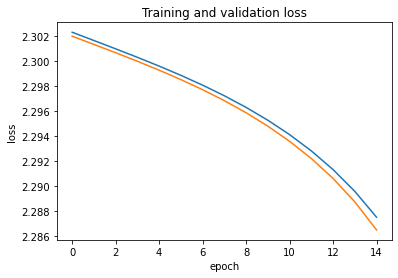

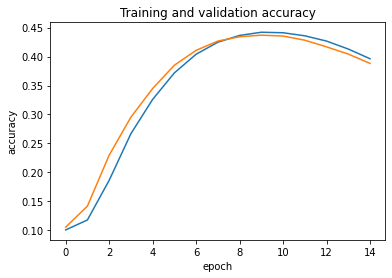

In [ ]:
# Training
train_test_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

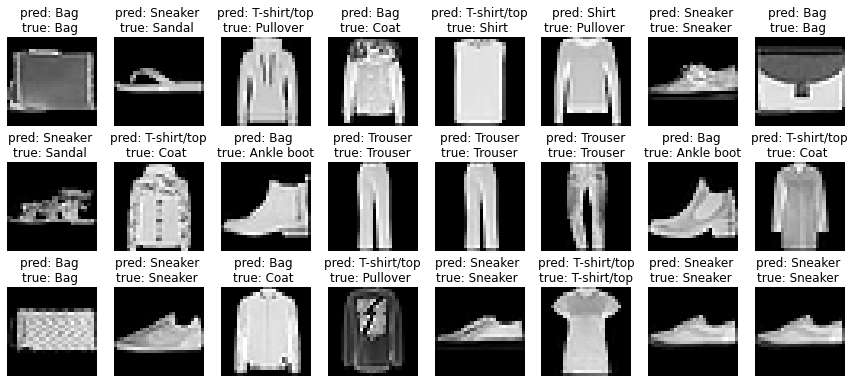

In [ ]:
print_random_pred(test_dataloader, model)

In [ ]:
print_acc_by_class(test_dataloader, model)

Accuracy for class T-shirt/top  is 82.8%
Accuracy for class Trouser      is 95.5%
Accuracy for class Pullover     is 0.0%
Accuracy for class Dress        is 22.3%
Accuracy for class Coat         is 0.0%
Accuracy for class Sandal       is 0.0%
Accuracy for class Shirt        is 5.3%
Accuracy for class Sneaker      is 88.0%
Accuracy for class Bag          is 94.3%
Accuracy for class Ankle boot   is 0.0%


In [ ]:
# Save model
PATH = './models/basic_nn.pth'
torch.save(model.state_dict(), PATH)

As expected this basic neural networks has a low accuracy (43.7% for 10 epochs). 
It is still better then a random prediction which would have an accuracy of 10%.

Yet when looking at the accuracy per class it is appears clearly that the model can it is not distributed equally on every class. This means that it does not fit properly the data.

In the next section we will add convolution layers on our basic models.

### 2. Convolutional Neural Network

Convolutional networks were inspired by biological processes in that the connectivity pattern between neurons resembles the organization of the animal visual cortex. Individual cortical neurons respond to stimuli only in a restricted region of the visual field known as the receptive field. The receptive fields of different neurons partially overlap such that they cover the entire visual field.

Source : [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)

By going through the image pixel by pixel (or pixel-group by pixel-group) they identify patterns that enables them to label each image with a probability of belonging to the category.

### 2.1. Basic CNN
Our basic convolutional neural network has two consecutive 2D convolution layers ([Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d)), activated by ReLU and followd by a MaxPool layer [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d).

![architecture](assets/basic_cnn.png)

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = BasicCNN().to(device)
print(model)

BasicCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Epoch 1
-------------------------------
loss: 2.298933  [    0/60000]
loss: 2.300755  [ 6400/60000]
loss: 2.298121  [12800/60000]
loss: 2.297044  [19200/60000]
loss: 2.292907  [25600/60000]
loss: 2.288109  [32000/60000]
loss: 2.276233  [38400/60000]
loss: 2.259666  [44800/60000]
loss: 2.232366  [51200/60000]
loss: 2.144310  [57600/60000]

Test Error: 
 Accuracy: 39.0%, Avg loss: 2.071747 

Epoch 2
-------------------------------
loss: 2.090830  [    0/60000]
loss: 1.577791  [ 6400/60000]
loss: 0.969975  [12800/60000]
loss: 1.001513  [19200/60000]
loss: 0.824045  [25600/60000]
loss: 0.854264  [32000/60000]
loss: 0.820657  [38400/60000]
loss: 0.766288  [44800/60000]
loss: 0.722451  [51200/60000]
loss: 0.824681  [57600/60000]

Test Error: 
 Accuracy: 71.4%, Avg loss: 0.714999 

Epoch 3
-------------------------------
loss: 0.642918  [    0/60000]
loss: 0.751327  [ 6400/60000]
loss: 0.541830  [12800/60000]
loss: 0.737627  [19200/60000]
loss: 0.625598  [25600/60000]
loss: 0.676055  [32000/6

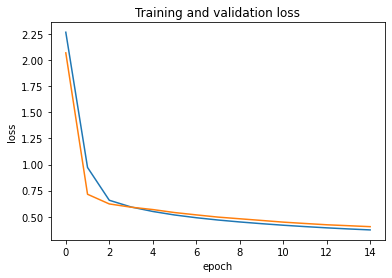

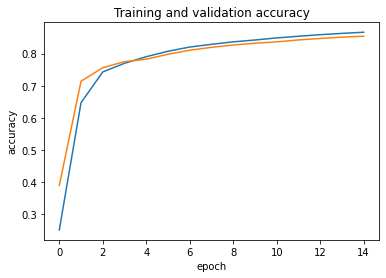

In [ ]:
# Training
train_test_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

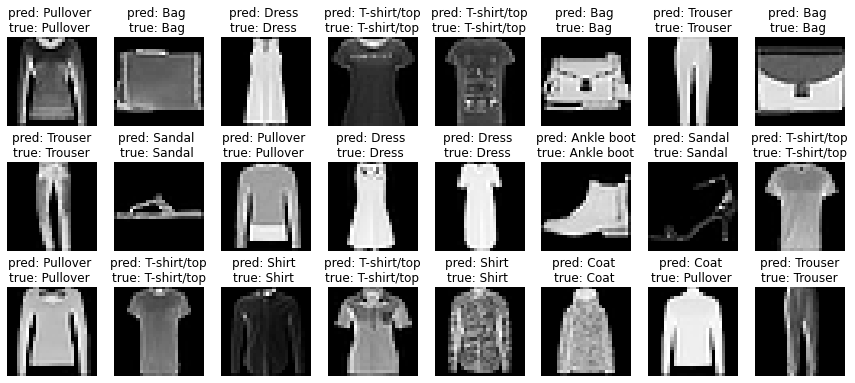

In [ ]:
print_random_pred(test_dataloader, model)

In [ ]:
print_acc_by_class(test_dataloader, model)

Accuracy for class T-shirt/top  is 82.9%
Accuracy for class Trouser      is 96.7%
Accuracy for class Pullover     is 63.5%
Accuracy for class Dress        is 88.5%
Accuracy for class Coat         is 84.7%
Accuracy for class Sandal       is 91.2%
Accuracy for class Shirt        is 61.9%
Accuracy for class Sneaker      is 94.2%
Accuracy for class Bag          is 95.7%
Accuracy for class Ankle boot   is 94.5%


In [ ]:
# Save model
PATH = './models/basic_cnn.pth'
torch.save(model.state_dict(), PATH)

Using convolution clearly improved our model's prediction. It's accuracy is now 85.4% for 15 epochs, which is more than twice the accuracy obtained with the basic neural network. Yet it can still be improved by complexifying its architecture.

### 2.2. Add layers
In the following model we choose to raise the size of the output of the different layers as well as to reduce the kernel to have a more precise pattern identification. 

We also add a dropout ([nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)) to prevent overfitting.

![architecture](assets/cnn.png)

In [ ]:
# Model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = self.pool(F.relu(self.norm2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(self.drop(x)))
        x = F.relu(self.fc2(self.drop(x)))
        x = self.fc3(self.drop(x))
        return x

In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Epoch 1
-------------------------------
loss: 2.286238  [    0/60000]
loss: 1.396340  [ 6400/60000]
loss: 0.651058  [12800/60000]
loss: 0.744561  [19200/60000]
loss: 0.681842  [25600/60000]
loss: 0.687957  [32000/60000]
loss: 0.534572  [38400/60000]
loss: 0.605862  [44800/60000]
loss: 0.599191  [51200/60000]
loss: 0.517876  [57600/60000]

Test Error: 
 Accuracy: 80.9%, Avg loss: 0.521381 

Epoch 2
-------------------------------
loss: 0.404603  [    0/60000]
loss: 0.485430  [ 6400/60000]
loss: 0.276550  [12800/60000]
loss: 0.478860  [19200/60000]
loss: 0.376615  [25600/60000]
loss: 0.555836  [32000/60000]
loss: 0.423646  [38400/60000]
loss: 0.629005  [44800/60000]
loss: 0.435729  [51200/60000]
loss: 0.338117  [57600/60000]

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.419751 

Epoch 3
-------------------------------
loss: 0.242421  [    0/60000]
loss: 0.403623  [ 6400/60000]
loss: 0.278308  [12800/60000]
loss: 0.481437  [19200/60000]
loss: 0.420906  [25600/60000]
loss: 0.513304  [32000/6

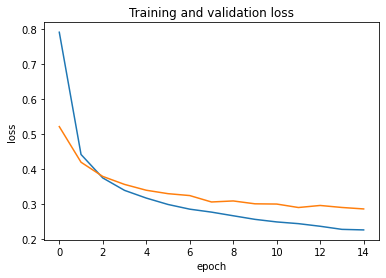

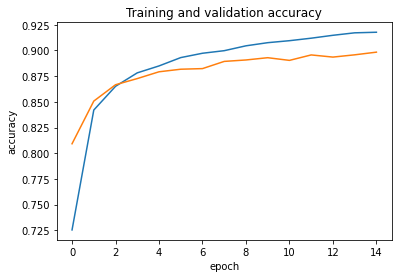

In [ ]:
# Training
train_test_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

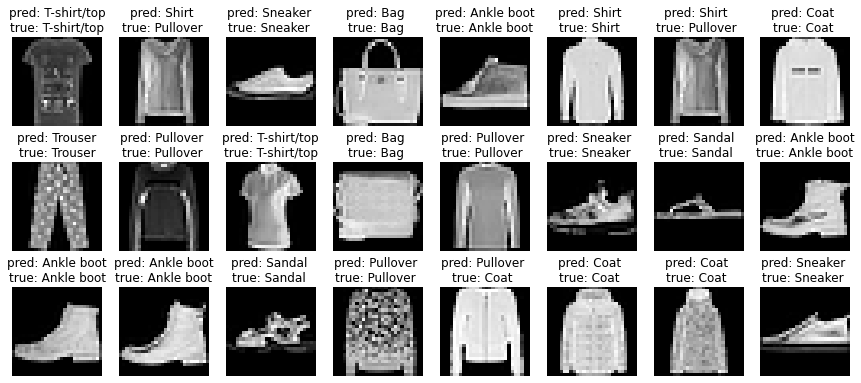

In [ ]:
print_random_pred(test_dataloader, model)

In [ ]:
print_acc_by_class(test_dataloader, model)

Accuracy for class T-shirt/top  is 89.9%
Accuracy for class Trouser      is 97.3%
Accuracy for class Pullover     is 84.7%
Accuracy for class Dress        is 91.4%
Accuracy for class Coat         is 82.4%
Accuracy for class Sandal       is 95.9%
Accuracy for class Shirt        is 64.8%
Accuracy for class Sneaker      is 95.6%
Accuracy for class Bag          is 97.9%
Accuracy for class Ankle boot   is 96.5%


In [ ]:
# Save model
PATH = './models/cnn.pth'
torch.save(model.state_dict(), PATH)

This model achieved an accuracy: 89.8% with a noteworthy improvement of the accuracy of pullover detection (from 63% to 84.7%!).

However the classification of shirt images is still unsatisfactory.

## Data Augmentation
In order to improve our model we can train it on a wider dataset. Instead of getting new images we will use the given dataset and tranform it (by applying rotation and translation). Thus our model will iterated on transformed data at each epoch.

We also introduce data normalization to enhance the prediction.

Finally the previous model architecture will not be modified for comparison and impact measurment purpose.

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Transform each image randomly
transform_train = transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Dataset
train_data = datasets.FashionMNIST('../data', train=True, download=True, transform=transform_train)
test_data = datasets.FashionMNIST('../data', train=False, download=True, transform=transform_test)

# Dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Epoch 1
-------------------------------
loss: 2.304564  [    0/60000]
loss: 1.681539  [ 6400/60000]
loss: 0.916608  [12800/60000]
loss: 0.934786  [19200/60000]
loss: 0.839659  [25600/60000]
loss: 0.911494  [32000/60000]
loss: 0.677028  [38400/60000]
loss: 0.732439  [44800/60000]
loss: 0.815123  [51200/60000]
loss: 0.655896  [57600/60000]

Test Error: 
 Accuracy: 76.4%, Avg loss: 0.635031 

Epoch 2
-------------------------------
loss: 0.538329  [    0/60000]
loss: 0.703181  [ 6400/60000]
loss: 0.397851  [12800/60000]
loss: 0.756175  [19200/60000]
loss: 0.617037  [25600/60000]
loss: 0.582539  [32000/60000]
loss: 0.508577  [38400/60000]
loss: 0.629504  [44800/60000]
loss: 0.692007  [51200/60000]
loss: 0.529299  [57600/60000]

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.538018 

Epoch 3
-------------------------------
loss: 0.446552  [    0/60000]
loss: 0.635365  [ 6400/60000]
loss: 0.332549  [12800/60000]
loss: 0.610989  [19200/60000]
loss: 0.428937  [25600/60000]
loss: 0.568262  [32000/6

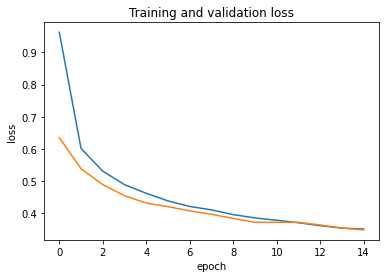

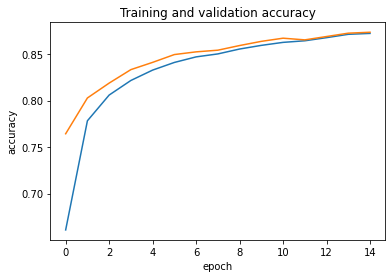

In [ ]:
# Training
train_test_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs)

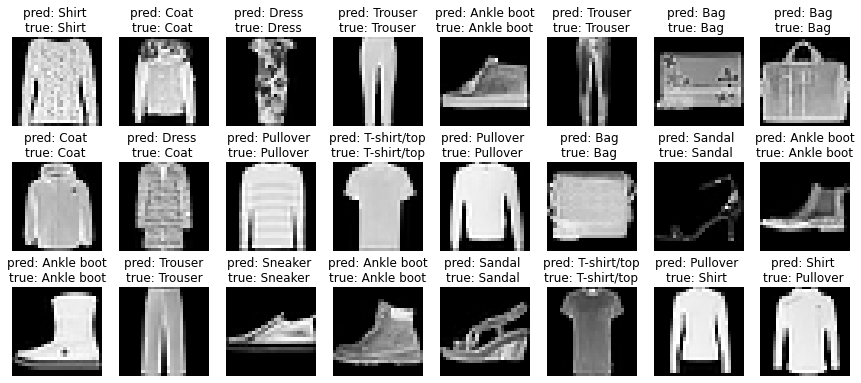

In [ ]:
print_random_pred(test_dataloader, model)

In [ ]:
print_acc_by_class(test_dataloader, model)

Accuracy for class T-shirt/top  is 84.6%
Accuracy for class Trouser      is 96.2%
Accuracy for class Pullover     is 78.3%
Accuracy for class Dress        is 91.0%
Accuracy for class Coat         is 87.4%
Accuracy for class Sandal       is 93.8%
Accuracy for class Shirt        is 57.7%
Accuracy for class Sneaker      is 94.4%
Accuracy for class Bag          is 96.7%
Accuracy for class Ankle boot   is 95.5%


In [ ]:
# Save model
PATH = './models/augmented_cnn.pth'
torch.save(model.state_dict(), PATH)

Unfortunately data augmentation was not a solution the issue we were facing. It actually lead to a decrease in prediction accuracy. 

However the accuracy and loss value of the training and validation are closer than on the previous experiment, which coul be interpreted as a correction of a previous overfitting phenomenon.

Nevertheless, the selected model is the compexified CNN (model 2.2) without data augmentation.

# To go deeper:

Use pre-trained models (vgg, alexNet, etc)

- [Image Classification of Fashion-mnist Data Set Based on VGG Network](http://166.62.7.99/conferences/ACSS/ISET%202019/SE004.pdf)
- [VGG Neural Networks: The Next Step After AlexNet](https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c)
- [(BETA) QUANTIZED TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)


Try and reduce correlation between shirts and other labels - probably pullover and/or tshirts (the dataset is balanced so nothing to do on this point)